In [1]:
import json
import os
import ml_collections
import torch
import matplotlib.pyplot as plt
import tqdm

from lightning.pytorch import seed_everything
from seisLM.model.foundation.pretrained_models import LitMultiDimWav2Vec2
from seisLM.data_pipeline import collator
from seisLM.model.foundation import pretrained_models

from seisLM.utils.project_path import gitdir
from seisLM.data_pipeline.pretrain_dataloaders import prepare_pretrain_dataloaders
from seisLM.data_pipeline.foreshock_aftershock_dataloaders import (
  prepare_foreshock_aftershock_dataloaders
)

DEFAULT_NUM_WORKERS = 4

/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def evaluate_self_supervised_loss(model, loader):
  all_losses = []
  for batch in tqdm.tqdm(loader):
    for k, v in batch.items():
      batch[k] = v.to(model.device)

    mask_time_indices = batch["mask_time_indices"]
    num_losses = mask_time_indices.sum()

    with torch.no_grad():
      out = model.model(**batch)
    all_losses.append(out.loss / num_losses)

  return sum(all_losses) / len(all_losses)

In [4]:
ckpt_dict = {
  # 'rope_12_epoch':  '/results/models/pretrained_seisLM/pretrain_config_layernorm_peak_mean_rope_small_batch_6_datasets_42__2024-08-04-03h-27m-23s/checkpoints/epoch=12-step=341744.ckpt',
  'rope_18_epoch':  '/results/models/pretrained_seisLM/pretrain_config_layernorm_peak_mean_rope_small_batch_6_datasets_42__2024-08-04-03h-27m-23s/checkpoints/epoch=18-step=499472.ckpt',
  # 'conv_14_epoch': '/results/models/pretrained_seisLM/pretrain_config_layernorm_peak_small_batch_6_datasets_42__2024-08-03-21h-32m-39s/checkpoints/epoch=14-step=394320.ckpt',
  'conv_20_epoch': '/results/models/pretrained_seisLM/pretrain_config_layernorm_peak_small_batch_6_datasets_42__2024-08-03-21h-32m-39s/checkpoints/epoch=20-step=552048.ckpt',
}

for ckpt_label, pretrained_ckpt_path in  ckpt_dict.items():

  pretrained_model_lit = pretrained_models.LitMultiDimWav2Vec2.load_from_checkpoint(
      gitdir() + pretrained_ckpt_path
  )

  config = pretrained_model_lit.config
  config.data_config.local_batch_size = 8
  model = pretrained_model_lit
  device = model.device

  model.eval()


  data_collator = \
    collator.DataCollatorForWav2Vec2PretrainingConcatChannelsNoPadding(
        config=config.model_config,
        mask_time_prob=config.training_config.mask_time_prob,
        mask_time_length=config.training_config.mask_time_length,
    )


  _, pretrain_dev_loaders = prepare_pretrain_dataloaders(
    model=model,
    training_fraction=config.data_config.training_fraction,
    data_names=['ETHZ', 'Iquique'], #config.data_config.data_name,
    batch_size=config.data_config.local_batch_size,
    num_workers=config.data_config.num_workers,
    prefetch_factor=config.data_config.prefetch_factor,
    collator=data_collator,
    cache=config.data_config.cache_dataset,
  )

  for val_name, val_loader in pretrain_dev_loaders.items():
    pretrain_loss = evaluate_self_supervised_loss(model, val_loader)
    print(f'ckpt {ckpt_label} pretrain loss, {pretrain_loss}, {val_name}')

2024-08-06 11:44:30,737 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
2024-08-06 11:44:30,992 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb
Seed set to 42
Seed set to 42
100%|██████████| 454/454 [00:27<00:00, 16.79it/s]


ckpt rope_18_epoch pretrain loss, 3.813591718673706, ETHZ


100%|██████████| 168/168 [00:10<00:00, 16.16it/s]


ckpt rope_18_epoch pretrain loss, 3.722299814224243, Iquique


100%|██████████| 91/91 [00:04<00:00, 18.70it/s]


ckpt rope_18_epoch pretrain loss, 4.039734840393066, shock


2024-08-06 11:45:16,626 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
2024-08-06 11:45:16,901 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb
Seed set to 42
Seed set to 42
100%|██████████| 454/454 [00:28<00:00, 15.77it/s]


ckpt conv_20_epoch pretrain loss, 3.900665521621704, ETHZ


100%|██████████| 168/168 [00:11<00:00, 15.21it/s]


ckpt conv_20_epoch pretrain loss, 3.8419861793518066, Iquique


100%|██████████| 91/91 [00:05<00:00, 17.49it/s]

ckpt conv_20_epoch pretrain loss, 3.956230878829956, shock


In [8]:
# 2024-08-06 10:01:27,147 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
# WARNING:seisbench:Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
# 2024-08-06 10:02:06,639 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb
# WARNING:seisbench:Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb
# /home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/seisbench/data/base.py:1573: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
#   self._metadata["trace_dataset"] = sum(
# /home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/seisbench/data/base.py:1573: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
#   self._metadata["trace_dataset"] = sum(
# Seed set to 42
# Seed set to 42
# 100%|██████████| 454/454 [00:27<00:00, 16.77it/s]
# ckpt rope_18_epoch pretrain loss, 3.7702200412750244, ETHZ
# 100%|██████████| 3461/3461 [03:21<00:00, 17.17it/s]
# ckpt rope_18_epoch pretrain loss, 3.521739959716797, GEOFON
# 100%|██████████| 7911/7911 [07:43<00:00, 17.08it/s]
# ckpt rope_18_epoch pretrain loss, 3.8675150871276855, STEAD
# 100%|██████████| 15331/15331 [14:56<00:00, 17.11it/s]
# ckpt rope_18_epoch pretrain loss, 3.52524733543396, NEIC
# 100%|██████████| 14379/14379 [14:01<00:00, 17.10it/s]
# ckpt rope_18_epoch pretrain loss, 3.7479248046875, InstanceCounts
# 100%|██████████| 168/168 [00:11<00:00, 15.20it/s]
# ckpt rope_18_epoch pretrain loss, 3.6535496711730957, Iquique
# 100%|██████████| 91/91 [00:05<00:00, 16.67it/s]
# ckpt rope_18_epoch pretrain loss, 4.040198802947998, shock
# 2024-08-06 10:43:27,691 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
# WARNING:seisbench:Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
# 2024-08-06 10:44:07,656 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb
# WARNING:seisbench:Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb
# /home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/seisbench/data/base.py:1573: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
#   self._metadata["trace_dataset"] = sum(
# /home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/seisbench/data/base.py:1573: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
#   self._metadata["trace_dataset"] = sum(
# Seed set to 42
# Seed set to 42
# 100%|██████████| 454/454 [00:29<00:00, 15.53it/s]
# ckpt conv_20_epoch pretrain loss, 3.8769397735595703, ETHZ
# 100%|██████████| 3461/3461 [03:34<00:00, 16.13it/s]
# ckpt conv_20_epoch pretrain loss, 3.579784393310547, GEOFON
# 100%|██████████| 7911/7911 [08:09<00:00, 16.15it/s]
# ckpt conv_20_epoch pretrain loss, 4.062901496887207, STEAD
# 100%|██████████| 15331/15331 [15:46<00:00, 16.19it/s]
# ckpt conv_20_epoch pretrain loss, 3.6335136890411377, NEIC
# 100%|██████████| 14379/14379 [14:48<00:00, 16.18it/s]
# ckpt conv_20_epoch pretrain loss, 3.9128518104553223, InstanceCounts
# 100%|██████████| 168/168 [00:12<00:00, 13.24it/s]
# ckpt conv_20_epoch pretrain loss, 3.792097568511963, Iquique
# 100%|██████████| 91/91 [00:06<00:00, 13.16it/s]
# ckpt conv_20_epoch pretrain loss, 3.961564302444458, shock
# 2024-08-06 10:01:27,147 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
# WARNING:seisbench:Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
# 2024-08-06 10:02:06,639 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb
# WARNING:seisbench:Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb
# /home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/seisbench/data/base.py:1573: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
#   self._metadata["trace_dataset"] = sum(
# /home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/seisbench/data/base.py:1573: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
#   self._metadata["trace_dataset"] = sum(
# Seed set to 42
# Seed set to 42
# 100%|██████████| 454/454 [00:27<00:00, 16.77it/s]
# ckpt rope_18_epoch pretrain loss, 3.7702200412750244, ETHZ
# 100%|██████████| 3461/3461 [03:21<00:00, 17.17it/s]
# ckpt rope_18_epoch pretrain loss, 3.521739959716797, GEOFON
# 100%|██████████| 7911/7911 [07:43<00:00, 17.08it/s]
# ckpt rope_18_epoch pretrain loss, 3.8675150871276855, STEAD
# 100%|██████████| 15331/15331 [14:56<00:00, 17.11it/s]
# ckpt rope_18_epoch pretrain loss, 3.52524733543396, NEIC
# 100%|██████████| 14379/14379 [14:01<00:00, 17.10it/s]
# ckpt rope_18_epoch pretrain loss, 3.7479248046875, InstanceCounts
# 100%|██████████| 168/168 [00:11<00:00, 15.20it/s]
# ckpt rope_18_epoch pretrain loss, 3.6535496711730957, Iquique
# 100%|██████████| 91/91 [00:05<00:00, 16.67it/s]
# ckpt rope_18_epoch pretrain loss, 4.040198802947998, shock
# 2024-08-06 10:43:27,691 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
# WARNING:seisbench:Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
# 2024-08-06 10:44:07,656 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb
# WARNING:seisbench:Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb
# /home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/seisbench/data/base.py:1573: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
#   self._metadata["trace_dataset"] = sum(
# /home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/seisbench/data/base.py:1573: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
#   self._metadata["trace_dataset"] = sum(
# Seed set to 42
# Seed set to 42
# 100%|██████████| 454/454 [00:29<00:00, 15.53it/s]
# ckpt conv_20_epoch pretrain loss, 3.8769397735595703, ETHZ
# 100%|██████████| 3461/3461 [03:34<00:00, 16.13it/s]
# ckpt conv_20_epoch pretrain loss, 3.579784393310547, GEOFON
# 100%|██████████| 7911/7911 [08:09<00:00, 16.15it/s]
# ckpt conv_20_epoch pretrain loss, 4.062901496887207, STEAD
# 100%|██████████| 15331/15331 [15:46<00:00, 16.19it/s]
# ckpt conv_20_epoch pretrain loss, 3.6335136890411377, NEIC
# 100%|██████████| 14379/14379 [14:48<00:00, 16.18it/s]
# ckpt conv_20_epoch pretrain loss, 3.9128518104553223, InstanceCounts
# 100%|██████████| 168/168 [00:12<00:00, 13.24it/s]
# ckpt conv_20_epoch pretrain loss, 3.792097568511963, Iquique
# 100%|██████████| 91/91 [00:06<00:00, 13.16it/s]
# ckpt conv_20_epoch pretrain loss, 3.961564302444458, shock


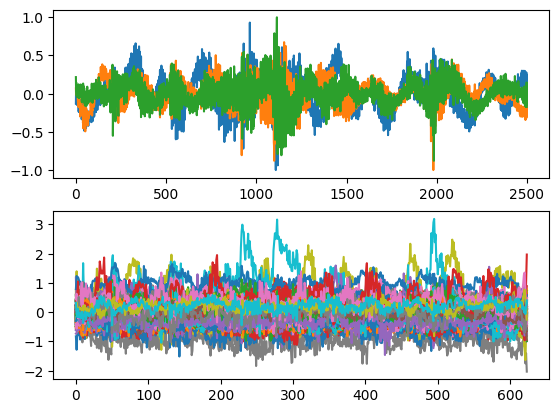

In [7]:
batch_shock = next(iter(pretrain_dev_loaders['shock']))

fig, axes = plt.subplots(2, 1)

axes[0].plot(batch_shock['input_values'][0].T)

for k, v in batch_shock.items():
  batch_shock[k] = v.to(model.device)

out = model.model.wav2vec2(batch_shock['input_values'])
axes[1].plot(out.last_hidden_state[0].detach().cpu());

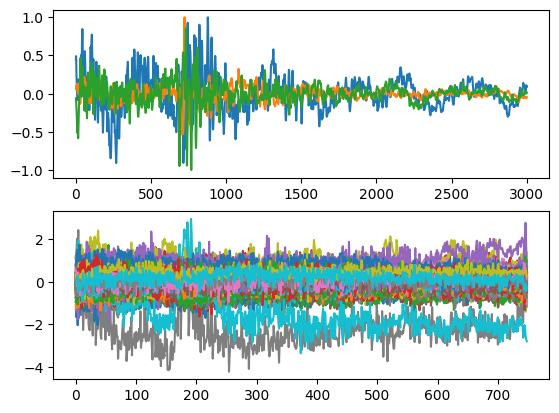

In [6]:
batch_pretrain_dev = next(iter(pretrain_dev_loader))

fig, axes = plt.subplots(2, 1)

axes[0].plot(batch_pretrain_dev['input_values'][0].T)

for k, v in batch_pretrain_dev.items():
  batch_pretrain_dev[k] = v.to(model.device)


out = model.model.wav2vec2(batch_pretrain_dev['input_values'])
axes[1].plot(out.last_hidden_state[0].detach().cpu());

